# Topic Modeling of News Groups

Adapted from [here](https://github.com/vatsan/text_analytics_on_mpp)

Let's next build a topic model (LDA - Latent Dirichlet Allocation) on the news groups posts from the  <i>demo.twenty_news_groups</i> table to uncover the underlying themes, in an unsupervised fashion. We'll then embed these posts in the topic space and build a classifier.
We'll use NLTK for tokenization.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from IPython.display import Image
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)

## Setup database connectivity


In [3]:
import pandas.io.sql as psql
import psycopg2
connect_credentials = {'database': 'postgres',
                       'host': '127.0.0.1',
                       'password': 'gpadmin',
                       'user': 'gpadmin',
                       'port': 5432}

# connect to postgres connection object
conn = psycopg2.connect(**connect_credentials)
conn.autocommit = True
# schema_name = 'template'
# psql.execute('SET search_path TO {}'.format(schema_name), conn)

%load_ext sql_magic
%config SQL.conn_name = 'conn'

## Process data

In [4]:
data = '21_newsgroups_processed_small.tsv'

In [5]:
# !python process_20_newsgroups.py '20_newsgroups' '20_newsgroups_processed.tsv'
!python process_20_newsgroups.py '20_newsgroups' '{data}'

19997 documents written to 21_newsgroups_processed_small.tsv


In [6]:
df = pd.read_csv(data, delimiter="\t", header=None)\
#        .sample(n=250)

## Load data and upload to db

In [7]:
print df.shape
df.columns = ['doc_id', 'contents', 'label']

# bytecode, utf-8 issue; this fixes it
# source: https://stackoverflow.com/questions/26541968/delete-every-non-utf-8-symbols-froms-string
df.contents = df.contents.str.decode('utf-8','ignore').str.encode("utf-8")

(19997, 3)


In [8]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://{user}:{password}@{host}:5432/{database}'.format(**connect_credentials))

%read_sql DROP SCHEMA IF EXISTS demo CASCADE;
%read_sql CREATE SCHEMA demo;
# %read_sql DROP TABLE IF EXISTS twenty_news_groups;

Query started at 12:46:45 PM EDT; Query executed in 0.00 m

In [9]:
df.to_sql('twenty_news_groups', engine, schema='demo', if_exists='replace', index=False)

In [10]:
%%read_sql tmp

SELECT COUNT(*) FROM demo.twenty_news_groups

Query started at 12:47:14 PM EDT; Query executed in 0.00 m

,count
0,19997


# Analysis

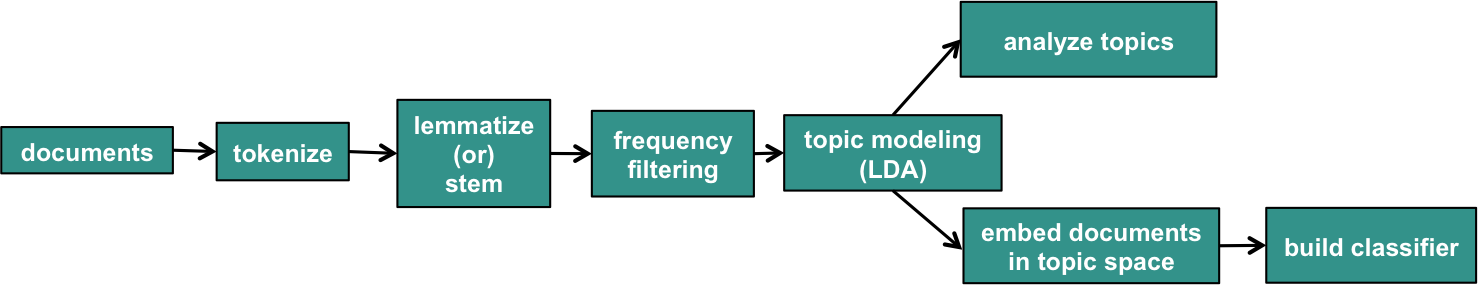

In [11]:
Image(filename='topic_analysis_pipeline.png')

In [12]:
%%read_sql df_head
select
    *
from
    demo.twenty_news_groups
limit 10;

Query started at 12:47:14 PM EDT; Query executed in 0.00 m

doc_id  \
0  1        
1  3        
2  5        
3  7        
4  9        
5  11       
6  13       
7  15       
8  17       
9  19       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [13]:
df.head()

doc_id  \
0  0        
1  1        
2  2        
3  3        
4  4        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [14]:
%%read_sql _

--1) Create UDF to invoke NLTK's tokenizer
drop type if exists demo.token_indx_pair cascade;
create type demo.token_indx_pair
as
(
    indx int,
    token text
);

Query started at 12:47:15 PM EDT; Query executed in 0.00 m

In [18]:
%%read_sql _

drop function if exists demo.word_tokenize_lemmatize(text) cascade;
create or replace function demo.word_tokenize_lemmatize(doc text)
returns setof demo.token_indx_pair
as
$$
    import pandas as pd
    from unicodedata import category as uc_cat
    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    import string, re

    #discard stopwords
    stop_en = stopwords.words('english')

    #Use a wordnet lemmatizer to stem the tokens
    wnl = WordNetLemmatizer()

    #tokenize the documents using NLTK
    tokens = [w.strip().decode('utf8') for sent in sent_tokenize(doc) 
              for w in word_tokenize(sent)] if doc else None

    if(not tokens):
        return [(0, None),]

    #Remove control characters
    tokens = map(lambda x: ''.join(c for c in x if uc_cat(c) != 'Cc'), tokens)

    #Remove punctuations if they are tokens by themselves
    tokens = filter(lambda x: x not in set(list(string.punctuation.decode('utf-8')))
                    , tokens)

    #Replace phone numbers with <PHONE>
    phone_pat = re.compile(r"""
                    # don't match beginning of string, number can start anywhere
        (\d{1,2}-?)?
        (\d{3})     # area code is 3 digits (e.g. '800')
        \D*         # optional separator is any number of non-digits
        (\d{3})     # trunk is 3 digits (e.g. '555')
        \D*         # optional separator
        (\d{4})     # rest of number is 4 digits (e.g. '1212')
        \D*         # optional separator
        (\d*)       # extension is optional and can be any number of digits
        $           # end of string
        """, re.VERBOSE)
    tokens = map(lambda x: u'<PHONE>' if phone_pat.match(x) else x, tokens)

    #Replace numbers with <NUM>
    num_pat = re.compile(r'^(-|\+)?(\d*).?(\d+)')
    tokens = map(lambda x: u'<NUM>' if num_pat.match(x) else x, tokens)

    #Replace dates
    date_pat =  re.compile(r'^(\d{1,2})(/|-)(\d{1,2})(/|-)(\d{2,4})$')
    tokens = map(lambda x: u'<DATE>' if date_pat.match(x) else x, tokens)

    #Remove tokens which are solely composed on non-alpha characters
    non_alpha = re.compile(r'^(\W+)$', re.VERBOSE)
    tokens = filter(lambda x: not non_alpha.match(x), tokens)

    #Strip out any lingering punctuations now that the document has been tokenized by NLTK
    tokens = map(lambda x: ''.join(c for c in x if not uc_cat(c).startswith('P')), tokens)

    #use the wordnet lemmatizer
    lemmatized_tokens = map(lambda x: wnl.lemmatize(x), tokens)

    #filter out empty tokens and stopwords
    lemmatized_tokens = filter(lambda x: x and x.strip() and x.strip() not in stop_en, lemmatized_tokens)

    #Include unigrams
    unigrams = [indx_tok for indx_tok in enumerate(lemmatized_tokens)] if doc else [(0, None),]
    result = []
    result.extend(unigrams)
    return result
$$
language plpythonu;
'''

'\n%%read_sql _\n\ndrop function if exists demo.word_tokenize_lemmatize(text) cascade;\ncreate or replace function demo.word_tokenize_lemmatize(doc text)\nreturns setof demo.token_indx_pair\nas\n$$\n    import sys; sys.path = [\'/anaconda/lib/python2.7/site-packages/\'] + sys.path\n    import pandas as pd\n    from unicodedata import category as uc_cat\n    from nltk.tokenize import word_tokenize, sent_tokenize\n    from nltk.stem import WordNetLemmatizer\n    from nltk.corpus import stopwords\n    import string, re\n\n    #discard stopwords\n    stop_en = stopwords.words(\'english\')\n\n    #Use a wordnet lemmatizer to stem the tokens\n    wnl = WordNetLemmatizer()\n\n    #tokenize the documents using NLTK\n    tokens = [w.strip().decode(\'utf8\') for sent in sent_tokenize(doc) for w in word_tokenize(sent)] if doc else None\n\n    if(not tokens):\n        return [(0, None),]\n\n    #Remove control characters\n    tokens = map(lambda x: \'\'.join(c for c in x if uc_cat(c) != \'Cc\'), t

In [ ]:
%%read_sql _

CREATE OR REPLACE FUNCTION demo.word_tokenize_lemmatize(doc text)
RETURNS SETOF demo.token_indx_pair
as
$$
    import pandas as pd
    from nltk.stem import WordNetLemmatizer
    import re

    #discard stopwords
    stop_en = stopwords.words('english')

    #Use a wordnet lemmatizer to stem the tokens
    wnl = WordNetLemmatizer()
    ...

    date_pat =  re.compile(r'^(\d{1,2})(/|-)(\d{1,2})(/|-)(\d{2,4})$')
    tokens = map(lambda x: u'<DATE>' if date_pat.match(x) else x, tokens)

    ...
    
    unigrams = [indx_tok for indx_tok in enumerate(lemmatized_tokens)] if doc else [(0, None),]
    result = []
    result.extend(unigrams)
    return result
    
$$
LANGUAGE PLPYTHONU;


In [19]:
%%read_sql _

--2) Tokenize the contents field to obtain raw tokens (without frequency filtering)
    select
        doc_id,
        (demo.word_tokenize_lemmatize(lower(contents))).*
    from
        (SELECT * FROM demo.twenty_news_groups LIMIT 1) q


Query started at 12:48:10 PM EDT; Query executed in 0.04 m

,doc_id,indx,token
0,1,0,xref
1,1,1,cantaloupesrvcscmuedu
2,1,2,altatheism51060
3,1,3,altatheismmoderated727
4,1,4,newsanswers7300
5,1,5,altanswers155
6,1,6,path
7,1,7,cantaloupesrvcscmuedu
8,1,8,crabapplesrvcscmuedu
9,1,9,fs7ececmuedu


In [20]:
%%read_sql _

--2) Tokenize the contents field to obtain raw tokens (without frequency filtering)
drop table if exists twenty_news_groups_tokenized_raw;
create temp table twenty_news_groups_tokenized_raw
as
(
    select
        doc_id,
        (demo.word_tokenize_lemmatize(lower(contents))).*
    from
        demo.twenty_news_groups
) 
-- distributed by (doc_id)
;

Query started at 12:48:12 PM EDT; Query executed in 5.77 m

In [21]:
%%read_sql _

--3) Filter-out infrequent tokens or tokens occurring in every document (non-informative).
drop table if exists twenty_news_groups_tokenized_freq_filtered;
create temp table twenty_news_groups_tokenized_freq_filtered
as
(
    select
        t1.token,
        t1.freq as tf,
        t2.num_docs as df,
        t3.total_docs
    from
    (
        select
            token,
            count(*) as freq
        from
            twenty_news_groups_tokenized_raw
        group by token
    ) t1,
    (
        select
            token,
            count(distinct doc_id) as num_docs
        from
            twenty_news_groups_tokenized_raw
        group by token                        
    ) t2,
    (
        select
            count(distinct doc_id) as total_docs
        from
            twenty_news_groups_tokenized_raw
    ) t3
    where
        t1.token = t2.token and
        -- Remove low frequency tokens (make vocabulary size manageable)
        -- by discarding tokens which haven't occurred in atleast 10 documents or has term_freq < 10
        (t2.num_docs > 10 or t1.freq >= 10) and
        -- Remove high-frequency tokens (equivalen to stop-words, uninformative)
        t2.num_docs < 0.98*t3.total_docs
) 
;

Query started at 12:53:58 PM EDT; Query executed in 0.08 m

In [22]:
%%read_sql df

select *
from
twenty_news_groups_tokenized_freq_filtered
order by tf desc

Query started at 12:54:03 PM EDT; Query executed in 0.00 m

,token,tf,df,total_docs
0,ax,61932,67,19997
1,nt,26066,10146,19997
2,wa,25167,8497,19997
3,organization,20043,19218,19997
4,apr,19630,18396,19997
5,gmt,17760,17015,19997
6,would,17050,8024,19997
7,one,16221,7845,19997
8,writes,14680,10545,19997
9,reference,13733,12817,19997


In [23]:
df.head(100)

,token,tf,df,total_docs
0,ax,61932,67,19997
1,nt,26066,10146,19997
2,wa,25167,8497,19997
3,organization,20043,19218,19997
4,apr,19630,18396,19997
5,gmt,17760,17015,19997
6,would,17050,8024,19997
7,one,16221,7845,19997
8,writes,14680,10545,19997
9,reference,13733,12817,19997


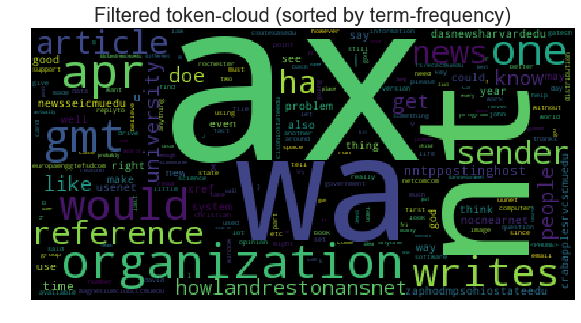

In [24]:
toks = dict(df[['token','tf']].values.tolist())
wordcloud = WordCloud().generate_from_frequencies(toks)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Filtered token-cloud (sorted by term-frequency)', fontsize=20)
plt.show()

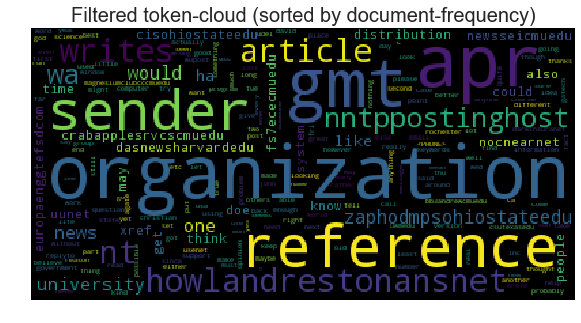

In [25]:
toks = dict(df[['token','df']].values.tolist())
wordcloud = WordCloud().generate_from_frequencies(toks)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Filtered token-cloud (sorted by document-frequency)', fontsize=20)
plt.show()


In [26]:
%%read_sql _

drop table if exists twenty_news_groups_tokenized_domain_stopwords cascade;
create temp table twenty_news_groups_tokenized_domain_stopwords
as
(
    select
        unnest(
            --Domain specific stopwords identified from tag-clouds above
            ARRAY[
                'would',
                'nt',
                'ax',
                'u',
                'wa',
                'said',
                're',
                'like',
                'say',
                'well',
                'o',
                'n',
                'b',
                'v',
                'w',
                'nntppostinghost'
            ]
        ) as domain_specific_stopword
);

Query started at 12:54:04 PM EDT; Query executed in 0.00 m

In [27]:
%%read_sql _

--1) Create table with infrequent tokens filtered out
drop table if exists demo.twenty_news_groups_tokenized cascade;
create table demo.twenty_news_groups_tokenized
as
(
    select
        *
    from
    (
        select
            doc_id as docid,
            array_agg(token order by token) as words
        from
        (
            select
                t1.doc_id,
                t1.token
            from
                twenty_news_groups_tokenized_raw t1 
                inner join
                twenty_news_groups_tokenized_freq_filtered t2
                on (t1.token = t2.token)
                -- Only consider those tokens in t1 that not present in t3
                left join
                twenty_news_groups_tokenized_domain_stopwords t3
                on (t1.token = t3.domain_specific_stopword)
            where
                -- since we're left joining on t3, we only consider those tokens in t1 which don't exist in t3
                t3.domain_specific_stopword is null
        )q
        group by docid
    )tbl
    where 
        --discard records which are empty (i.e. all their tokens were filtered out)
        array_upper(words, 1) > 0
) ;

Query started at 12:54:04 PM EDT; Query executed in 0.07 m

In [28]:
# /usr/local/greenplum-db-4.3.16.1/madlib/Versions/1.11/madpack/madpack.py install -s madlib -p greenplum -c gpadmin@localhost:5432/postgres

In [29]:
%%read_sql _

--2) LDA input table
drop table if exists twenty_news_groups_lda_input;
drop table if exists twenty_news_groups_lda_input_vocabulary;
drop table if exists demo.twenty_news_groups_lda_input;
drop table if exists demo.twenty_news_groups_lda_input;
drop table if exists demo.twenty_news_groups_lda_input_vocabulary;
select madlib.term_frequency('demo.twenty_news_groups_tokenized', 'docid', 'words', 'twenty_news_groups_lda_input', TRUE);
create table demo.twenty_news_groups_lda_input as select * from twenty_news_groups_lda_input ;
create table demo.twenty_news_groups_lda_input_vocabulary as select * from twenty_news_groups_lda_input_vocabulary ;

Query started at 12:54:17 PM EDT; Query executed in 0.02 m

```sql
SELECT * 
FROM demo.twenty_news_groups_lda_input 
```

In [30]:
%%read_sql tmp

select * from demo.twenty_news_groups_lda_input order by random() limit 10;

Query started at 12:54:19 PM EDT; Query executed in 0.02 m

,docid,wordid,count
0,18330,23408,4
1,19968,267,5
2,9246,9539,1
3,11256,9466,1
4,13134,17705,1
5,13775,17877,2
6,714,4263,4
7,1,4137,1
8,13222,17163,1
9,11430,17287,1


In [31]:
tmp.head()

,docid,wordid,count
0,18330,23408,4
1,19968,267,5
2,9246,9539,1
3,11256,9466,1
4,13134,17705,1


In [32]:
%%read_sql vocabulary_size

select count(distinct wordid) as voc_size from demo.twenty_news_groups_lda_input

Query started at 12:54:20 PM EDT; Query executed in 0.02 m

,voc_size
0,25166


In [33]:
voc_size = vocabulary_size['voc_size'][0]

In [61]:
%%read_sql tmp

drop table if exists demo.twenty_news_groups_lda_mdl cascade;
drop table if exists demo.twenty_news_groups_lda_results cascade;

select 
    madlib.lda_train(
        'demo.twenty_news_groups_lda_input', -- data_table',
        'demo.twenty_news_groups_lda_mdl', -- model_table',
        'demo.twenty_news_groups_lda_results', -- output_data_table',
        {voc_size}, -- voc_size,
        15, -- topic_num,
        50, -- iter_num,
        0.05, -- alpha (recommended = 50/topic_num),
        0.05 -- beta
    );

Query started at 02:19:50 PM EDT; Query executed in 1.19 m

,lda_train
0,"(demo.twenty_news_groups_lda_mdl,""model table"")"
1,"(demo.twenty_news_groups_lda_results,""output data table"")"


```sql
SELECT madlib.lda_train(
        'demo.twenty_news_groups_lda_input', -- data_table',
        'demo.twenty_news_groups_lda_mdl', -- model_table',
        'demo.twenty_news_groups_lda_results', -- output_data_table',
        {voc_size}, -- voc_size,
        40, -- topic_num,
        50, -- iter_num,
        0.05, -- alpha (recommended = 50/topic_num),
        0.05 -- beta
    );
```

In [62]:
%%read_sql tmp

select 
    madlib.lda_get_perplexity( 
        'demo.twenty_news_groups_lda_mdl',
        'demo.twenty_news_groups_lda_results'
    );

Query started at 02:21:02 PM EDT; Query executed in 0.01 m

,lda_get_perplexity
0,2533.233167


In [63]:
%%read_sql tmp

select * from demo.twenty_news_groups_lda_mdl;

Query started at 02:21:03 PM EDT; Query executed in 0.00 m

,voc_size,topic_num,alpha,beta,model
0,25166,15,0.05,0.05,"[8589934592, 0, 30064771072, 4294967296, 0, 9, 0, 0, 5, 7, 17179869184, 163208757248, 0, 0, 0, 0, 0, 0, 17179869184, 81604378624, 0, 0, 0, 0, 21474836502, 0, 171798691851, 21474836624, 231928233984, 0, 205, 30, 60, 0, 60129542144, 18, 249108103168, 0, 128, 11, 17179869185, 3, 12884901888, 10, 8589934599, 4, 21474836480, 0, 0, 0, 0, 7, 38654705664, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 304942678016, 0, 0, 1, 0, 0, 15, 0, 55834574848, 0, 0, 0, 0, 0, 9, 0, 81604378624, 2, 0, 0, 0, 0, 0, 0, 77309411328, 0, 0, 0, 0, 0, 0, 0, 154618822656, ...]"


In [64]:
%%read_sql tmp

select * from demo.twenty_news_groups_lda_results limit 10;

Query started at 02:21:03 PM EDT; Query executed in 0.00 m

,docid,wordcount,words,counts,topic_count,topic_assignment
0,1,2565,"[8608, 23916, 11317, 16828, 20702, 3064, 4178, 18208, 16957, 12786, 15954, 19524, 17850, 7900, 24482, 12876, 2843, 12546, 6383, 19470, 13795, 8145, 22287, 15329, 8359, 6052, 17169, 1421, 3525, 15499, 11325, 21343, 4254, 18593, 9187, 13785, 3222, 16959, 19564, 14797, 10663, 741, 19892, 7169, 6734, 7173, 20728, 12140, 24573, 13983, 7990, 19525, 2744, 891, 22053, 3091, 6058, 15533, 2842, 17179, 1108, 18922, 23982, 3467, 15555, 1495, 19908, 20868, 20241, 5370, 18714, 18689, 12542, 14023, 22295, 478, 17378, 15252, 16626, 149, 8471, 3549, 23955, 12602, 15778, 9100, 20172, 17418, 12894, 17181, 5869, 22025, 2103, 6571, 18150, 11012, 18684, 1547, 10084, 3711, ...]","[1, 1, 1, 1, 1, 4, 1, 1, 2, 2, 2, 7, 3, 3, 4, 2, 1, 1, 23, 1, 1, 1, 1, 1, 2, 4, 1, 2, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 2, 1, 4, 1, 1, 2, 1, 2, 3, 5, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 4, 1, 1, 1, 7, 1, 90, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 4, 1, 1, 25, 1, 4, 1, 1, 2, 1, 15, ...]","[0, 915, 31, 0, 4, 0, 0, 0, 0, 0, 279, 1336, 0, 0, 0]","[10, 11, 11, 11, 11, 10, 11, 1, 1, 11, 1, 1, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1, 1, 10, 1, 1, 11, 1, 11, 10, 1, 1, 11, 1, 11, 10, 1, 1, 1, 1, 11, 11, 1, 10, 11, 1, 1, 1, 11, 11, 11, 1, 11, 1, 10, 1, 11, 11, 11, 11, 1, 1, 10, 11, 11, 11, 11, 11, 11, 11, 1, 11, 11, 11, 11, 1, 11, 11, 11, 1, 1, 2, 11, 11, 1, 11, 1, 1, 11, 1, 10, 11, 11, 11, ...]"
1,3,137,"[7294, 19564, 23824, 19223, 18475, 16660, 19767, 20707, 17705, 22260, 6349, 4877, 16759, 8678, 17190, 15232, 713, 17301, 23018, 10439, 6442, 24453, 16644, 23549, 15632, 18214, 10226, 17092, 13008, 9779, 3105, 4578, 1444, 12051, 8579, 13476, 23221, 1414, 5647, 14893, 18687, 21314, 18474, 19479, 20869, 4721, 17848, 2238, 17068, 23491, 3188, 16309, 19652, 9584, 24661, 21373, 24628, 3711, 9591, 24811, 21095, 9083, 13321, 10985, 21575, 16252, 3088, 13322, 4090, 14987, 22125, 19887, 8608, 21233, 13492, 19669, 15045, 15879, 15736, 13743, 1754, 18656, 6122, 1168, 21577, 14911, 20708, 3735, 17904, 1951, 9023, 13739, 15894, 20679, 24787, 8316, 23406, 7523, 10723, 1108, ...]","[1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]","[0, 48, 0, 0, 20, 0, 0, 0, 1, 3, 36, 29, 0, 0, 0]","[10, 1, 4, 10, 1, 1, 1, 1, 11, 1, 4, 10, 1, 1, 10, 10, 10, 4, 10, 11, 9, 10, 4, 11, 1, 1, 10, 11, 4, 1, 10, 1, 11, 11, 10, 11, 11, 11, 11, 10, 10, 10, 1, 10, 1, 11, 1, 4, 1, 11, 1, 11, 11, 10, 1, 1, 1, 1, 1, 1, 1, 10, 11, 1, 11, 4, 10, 11, 10, 1, 10, 1, 4, 11, 10, 10, 10, 1, 1, 10, 10, 10, 10, 10, 4, 4, 1, 11, 1, 1, 4, 1, 10, 1, 1, 1, 1, 4, 1, 4, ...]"
2,0,964,"[18474, 1160, 14925, 14280, 711, 19743, 3098, 23408, 19767, 4596, 5691, 13795, 17639, 1526, 24555, 14790, 2164, 5669, 12399, 18671, 10878, 4538, 9094, 13321, 23119, 20703, 3712, 21192, 7748, 3545, 17896, 15879, 877, 21277, 10939, 22753, 18513, 5645, 14304, 2200, 4640, 9615, 17375, 5861, 3139, 16936, 13334, 1606, 22295, 21146, 4638, 20717, 22260, 12429, 3181, 24600, 8338, 20476, 21736, 1064, 4040, 15893, 3457, 8990, 3706, 19562, 13341, 13237, 16502, 17829, 23569, 1754, 16511, 22167, 6282, 19524, 12536, 5524, 17238, 3920, 1658, 18371, 3551, 7572, 18436, 180, 9496, 4440, 5522, 13221, 18784, 11686, 659, 24482, 18790, 10471, 7720, 11716, 14100, 7712, ...]","[6, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 4, 1, 3, 1, 2, 1, 1, 4, 1, 1, 1, 2, 3, 1, 4, 1, 1, 2, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 2, 2, 4, 1, 2, 1, 3, 1, 1, ...]","[0, 160, 156, 14, 0, 0, 112, 0, 0, 0, 0, 492, 30, 0, 0]","[11, 1, 11, 1, 11, 1, 1, 2, 6, 2, 11, 6, 11, 12, 2, 1, 6, 1, 1, 11, 2, 11, 2, 6, 12, 1, 1

In [65]:
%%read_sql _
--1) Topic to word mapping
drop table if exists topic_word_map cascade;
create temp table topic_word_map
as
(
    select
        topicid,
        wordid,
        count(*) as count
    from
    (
        select
            unnest(topic_assignment) as topicid,
            unnest(words) as wordid
        from
            demo.twenty_news_groups_lda_results
    )q
    group by topicid, wordid
) distributed randomly;

--2) Compute topics as a distribution over words
drop table if exists demo.twenty_news_groups_lda_topic_probs cascade;
create table demo.twenty_news_groups_lda_topic_probs
as
(
    select
        --adding 1 to topicid, coz PCA requires id column to be from 1 to N
        topicid+1 as topic_num_plus1,
        array_agg(prob order by wordid) as topic_prob_arr
    from
    (
        select
            topicid,
            wordid,
            count::float8/sum(count) over() as prob
        from
        (
            select
                topicid,
                wordid,
                sum(count) as count
            from
            (
                select
                    topicid,
                    wordid,
                    count
                from
                    topic_word_map
                union all
                select
                    topicid,
                    wordid,
                    0 as count
                from
                (
                    select
                        topicid
                    from
                        topic_word_map
                    group by topicid
                )t1,
                (
                    select
                        wordid
                    from
                        topic_word_map
                    group by wordid
                )t2
            ) tbl1
            group by 1, 2
        ) tbl2
    ) tbl3
    group by 1
) distributed by (topic_num_plus1);


Query started at 02:24:31 PM EDT; Query executed in 0.03 m

In [66]:
%%read_sql _
--1) Compute PCA
drop table if exists demo.twenty_news_groups_lda_topic_probs_pca;
drop table if exists demo.twenty_news_groups_lda_topic_probs_pca_mean;
select
    madlib.pca_train( 
        'demo.twenty_news_groups_lda_topic_probs',
        'demo.twenty_news_groups_lda_topic_probs_pca', -- result table
        'topic_num_plus1', -- id column
        2 -- top-k principal components
    );

--2) Project original topics, into top-2 principal components
drop table if exists demo.twenty_news_groups_lda_topic_probs_pca_projected_residuals;
drop table if exists demo.twenty_news_groups_lda_topic_probs_pca_projected_summary_table;
drop table if exists demo.twenty_news_groups_lda_topic_probs_pca_projected;
select 
    madlib.pca_project( 
    'demo.twenty_news_groups_lda_topic_probs', -- input table
    'demo.twenty_news_groups_lda_topic_probs_pca', -- table with principal components
    'demo.twenty_news_groups_lda_topic_probs_pca_projected', --results table
    'topic_num_plus1', -- id column
    'demo.twenty_news_groups_lda_topic_probs_pca_projected_residuals',
    'demo.twenty_news_groups_lda_topic_probs_pca_projected_summary_table'
);


Query started at 02:24:38 PM EDT; Query executed in 0.04 m

,pca_project
0,


```sql
SELECT madlib.pca_project( 
    'demo.twenty_news_groups_lda_topic_probs', -- input table
    'demo.twenty_news_groups_lda_topic_probs_pca', -- table with PCs
    'demo.twenty_news_groups_lda_topic_probs_pca_projected', --results table
    'topic_num_plus1', -- id column
    'demo.twenty_news_groups_lda_topic_probs_pca_projected_residuals',
    'demo.twenty_news_groups_lda_topic_probs_pca_projected_summary_table'
);
```

In [81]:
%%read_sql df
select
    t1.*,
    t2.num_docs
from    
(
    select
        row_id - 1 as topicid,
        row_vec[1] as pc_1,
        row_vec[2] as pc_2
    from
        demo.twenty_news_groups_lda_topic_probs_pca_projected
)t1,
(
    -- For each topic, find the number of documents in which it is the majority
    select
        topicid,
        count(distinct docid) as num_docs
    from
    (
        select
            docid,
            topicid,
            rank() over(partition by docid order by count desc) as rank
        from
        (
            select
                docid,
                topicid,
                count(*) as count
            from
            (
                select
                    docid,
                    unnest(topic_assignment) as topicid
                from
                    demo.twenty_news_groups_lda_results
            )q1
            group by docid, topicid
        )q2
    )q3
    where rank=1
    group by topicid
)t2
where t1.topicid = t2.topicid
order by 1;

Query started at 02:33:14 PM EDT; Query executed in 0.01 m

,topicid,pc_1,pc_2,num_docs
0,0,0.000259,-0.000039,1944
1,1,-0.000168,-0.000597,1520
2,2,-0.001109,0.000739,301
3,3,0.000596,0.000016,748
4,4,-0.000700,-0.000636,581
5,5,-0.001284,0.000672,4078
6,6,0.000486,0.000199,2100
7,7,0.000921,0.000384,110
8,8,-0.000041,-0.000069,1170
9,9,0.000156,0.000021,2634


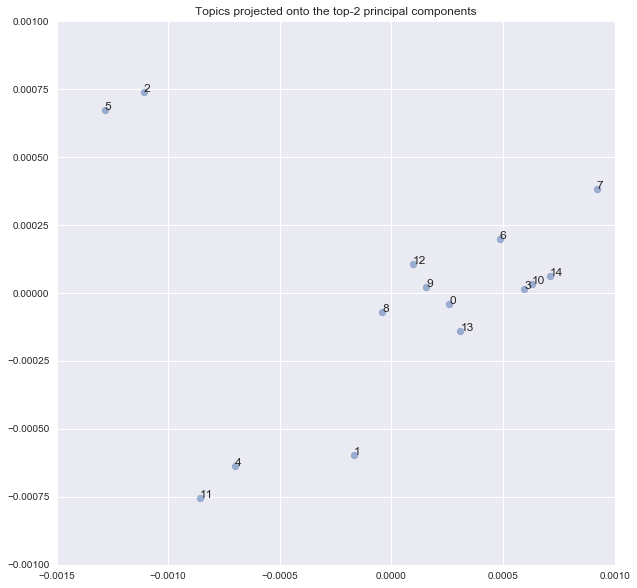

In [86]:
def drawTopicScatter(topicids, num_docs, pc_1, pc_2):
    """
       Draw scatterplot of topics
    """
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    colors = np.random.rand(len(topicids))
    #Area of circles on a 0 to 200 scale
    areas = [np.pi*(30*n*1.0/np.max(num_docs))**2 for n in num_docs]
    #ax.scatter(pc_1, pc_2, s=areas, alpha=0.5)
    ax.scatter(pc_1, pc_2, alpha=0.5)
    for i, txt in enumerate(topicids):
        ax.annotate(txt, (pc_1[i],pc_2[i]))
    plt.title('Topics projected onto the top-2 principal components')
    plt.xlim([-0.0015, 0.001])
    plt.ylim([-0.001, 0.001])
    plt.show()
#
drawTopicScatter(df['topicid'], df['num_docs'], df['pc_1'], df['pc_2'])


In [69]:
%%read_sql tsne_df

select
    t1.*,
    t2.num_docs
from
(
    select
        topic_num_plus1 - 1 as topicid,
        topic_prob_arr
    from
        demo.twenty_news_groups_lda_topic_probs
)t1,
(
    -- For each topic, find the number of documents in which it is the majority
    select
        topicid,
        count(distinct docid) as num_docs
    from
    (
        select
            docid,
            topicid,
            rank() over(partition by docid order by count desc) as rank
        from
        (
            select
                docid,
                topicid,
                count(*) as count
            from
            (
                select
                    docid,
                    unnest(topic_assignment) as topicid
                from
                    demo.twenty_news_groups_lda_results
            )q1
            group by docid, topicid
        )q2
    )q3
    where rank=1
    group by topicid
)t2
where t1.topicid = t2.topicid


Query started at 02:24:41 PM EDT; Query executed in 0.02 m

,topicid,topic_prob_arr,num_docs
0,1,"[2.6459495126e-08, 3.30743689075e-09, 1.65371844538e-09, 2.21929015369e-06, 4.68002320041e-07, 5.42419650083e-07, 0.0, 0.0, 4.96115533613e-09, 3.30743689075e-09, 1.86870184327e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.65371844538e-09, 1.65371844538e-09, 1.85216465882e-07, 0.0, 4.96115533613e-09, 0.0, 1.65371844538e-09, 1.15760291176e-08, 3.30743689075e-09, 1.65371844538e-09, 0.0, 2.48057766806e-07, 0.0, 1.15760291176e-08, 3.30743689075e-09, 0.0, 0.0, 0.0, 3.59518390025e-06, 1.15760291176e-08, 1.63718126092e-07, 1.6801779405e-06, 0.0, 2.14983397899e-08, 1.55449533865e-07, 1.65371844538e-09, 0.0, 1.37424002811e-06, 2.14983397899e-08, 8.26859222688e-09, 0.0, 5.62264271428e-08, 6.65290930575e-06, 4.11445149209e-06, 2.81132135714e-08, 6.26759290797e-07, 0.0, 1.15760291176e-08, 2.11675961008e-07, 3.30743689075e-09, 1.47511685328e-06, 1.00744527692e-05, 3.63818057983e-08, 1.5379581542e-07, 9.2608232941e-07, 1.73640436764e-07, 1.15760291176e-08, 1.65371844538e-09, 1.15760291176e-08, 2.31520582353e-08, 8.26859222688e-09, 2.6459495126e-08, 0.0, 1.76947873655e-07, 5.06037844285e-07, 3.30743689075e-09, 1.65371844538e-09, 1.98446213445e-08, 1.48834660084e-08, 8.83085649831e-07, 3.30743689075e-09, 2.56491730878e-06, 2.13660423143e-06, 1.55747203185e-05, 1.24028883403e-07, 3.82736596998e-05, 8.26859222688e-09, 1.65371844538e-08, 0.0, 2.72863543487e-07, 2.02580509559e-06, 4.46503980251e-08, 5.57799231625e-06, 2.66083297861e-06, 3.90277553109e-07, 2.08368524117e-06, 3.99703748247e-06, 7.9378485378e-08, 1.15760291176e-08, 2.8063602018e-06, ...]",1520
1,0,"[2.48057766806e-07, 3.22475096848e-07, 3.30743689075e-09, 4.0962605892e-06, 3.91765899709e-06, 2.16637116344e-07, 1.3229747563e-08, 2.61287514369e-06, 1.65371844538e-09, 0.0, 0.0, 1.65371844538e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.65371844538e-09, 0.0, 0.0, 0.0, 1.65371844538e-09, 1.65371844538e-09, 0.0, 6.25105572352e-07, 1.15760291176e-08, 1.65371844538e-09, 1.65371844538e-09, 4.25005640462e-07, 1.65371844538e-09, 5.2918990252e-08, 3.15860223067e-07, 1.30974500874e-06, 1.65371844538e-09, 0.0, 3.73409624966e-06, 0.0, 0.0, 0.0, 1.48834660084e-08, 6.7934753736e-06, 1.65371844538e-09, 6.06914669453e-07, 0.0, 8.26859222688e-09, 9.59156698318e-08, 2.10518358096e-06, 7.9378485378e-08, 0.0, 5.21252053982e-06, 0.0, 1.98446213445e-08, 1.28940427186e-05, 5.62264271428e-08, 2.81132135714e-08, 2.97669320168e-08, 0.0, 4.29966795798e-08, 1.24028883403e-07, 5.2918990252e-08, 1.51149865907e-06, 1.06995583416e-06, 1.60691821337e-05, 0.0, 1.7529415521e-07, 4.96115533613e-09, 1.65371844538e-08, 1.02530543613e-07, 5.45727086974e-08, 3.30743689075e-09, 8.26859222688e-09, 1.30643757185e-07, 4.96115533613e-09, 1.3229747563e-08, 3.30743689075e-09, 0.0, 2.26559427016e-07, 4.96115533613e-09, 4.79578349159e-08, 8.93007960503e-08, 1.43708132903e-05, 2.31520582353e-08, 3.08451564431e-05, 1.65371844538e-09, 8.26859222688e-09, 1.71821346475e-06, 7.27636115965e-08, 4.96115533613e-09, 3.40831371592e-06, 5.45727086974e-08, 1.15760291176e-08, 4.13429611344e-08, 0.0, 1.15760291176e-08, 3.47280873529e-08, 1.28990038739e-07, 8.93007960503e-08, ...]",1944
2,2,"[3.63818057983e-08, 1.48437767657e-05, 1.65371844538e-09, 6.13529543234e-07, 2.13991166832e-06, 9.79001319662e-07, 5.12652718066e-08, 0.0, 1.17414009622e-07, 1.49446535909e-05, 1.21796363502e-05, 1.17414009622e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.27336320294e-07, 1.55449533865e-07, 1.17414009622e-07, 1.65371844538e-09, 1.47180941638e-07, 1.17414009622e-07, 4.14421842411e-06, 1.17414009622e-07, 1.17414009622e-07, 8.26859222688e-09, 6.6148737815e-09, 1.65371844538e-09, 0.0, 3.80355242436e-07, 1.17414009622e-07, 7.52772636335e-06, 6.6148737815e-09, 3.30743689075e-09, 1.17414009622e-07, 0.0, 4.23517293861e-06, 3.30743689075e-09, 1.65371844538e-09, 1.65371844538e-09, 0.0, 6.44950193696e-08, 9.92231067225e-09, 4.99422970503e-07, 8.26859222688e-09, 3.30743689075e-07, 4.53118854033e-07, 4.96115533613e-09, 2.8609329105e-07, 0.

In [70]:
import sklearn
from sklearn.manifold import TSNE
tsne_mat = np.array(tsne_df['topic_prob_arr'].tolist())
topics_proj = TSNE(random_state=20150912).fit_transform(tsne_mat)


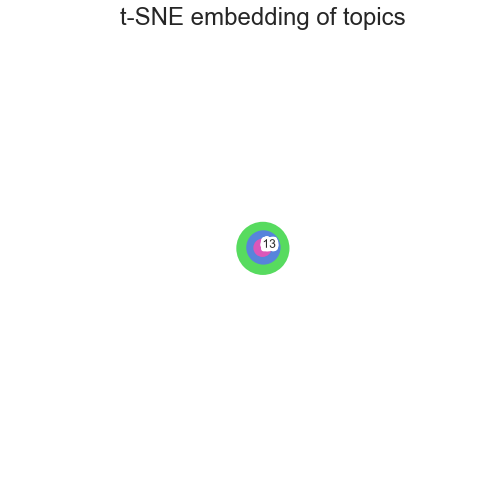

In [71]:
def scatterTSNE(title, mat, labels, sizes):
    """
        Based on https://github.com/oreillymedia/t-SNE-tutorial
    """
    import matplotlib.patheffects as PathEffects
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", len(labels)))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sizes = [np.pi*(30.0*s/np.max(sizes))**2 for s in sizes]
    sc = ax.scatter(mat[:,0], mat[:,1], lw=0, s=sizes,
                    c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(len(labels)):
        # Position of each label.
        xtext, ytext = mat[i, :]
        txt = ax.text(xtext, ytext, '{0}'.format(labels[i]), fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title(title, fontsize=24)
    plt.show()

scatterTSNE('t-SNE embedding of topics', topics_proj, tsne_df['topicid'].tolist(), tsne_df['num_docs'].tolist())


In [72]:
%%read_sql _
drop table if exists demo.twenty_news_groups_lda_topic_desc cascade;
select 
    madlib.lda_get_topic_desc( 
    'demo.twenty_news_groups_lda_mdl', -- model table
    'demo.twenty_news_groups_lda_input_vocabulary', -- word_id to word mapping (vocabulary table)
    'demo.twenty_news_groups_lda_topic_desc', -- output table
    50 -- top_k words for the given topic
);


Query started at 02:24:43 PM EDT; Query executed in 0.02 m

,lda_get_topic_desc
0,"(demo.twenty_news_groups_lda_topic_desc,""topic description, use """"ORDER BY topicid, prob DESC"""" to check the\n results"")"


In [73]:
%%read_sql df_topic_dist

select 
    topicid - 1 as topicid,
    wordid,
    prob,
    word
from 
    demo.twenty_news_groups_lda_topic_desc 
order by 
    topicid, prob desc;

Query started at 02:24:44 PM EDT; Query executed in 0.00 m

,topicid,wordid,prob,word
0,0,8764,0.012675,game
1,0,21955,0.008489,team
2,0,1168,0.007765,apr
3,0,15879,0.007595,organization
4,0,24924,0.006396,year
5,0,9083,0.006315,gmt
6,0,16869,0.006239,player
7,0,18330,0.005303,reference
8,0,24628,0.005170,writes
9,0,14911,0.005137,news


In [90]:
df_topic_dist.query("topicid == 5")

,topicid,wordid,prob,word
246,5,24417,0.009090,window
247,5,15879,0.008354,organization
248,5,1168,0.008133,apr
249,5,9083,0.007392,gmt
250,5,6574,0.006066,drive
251,5,17378,0.005793,problem
252,5,8116,0.005779,file
253,5,21777,0.005727,system
254,5,10226,0.005192,howlandrestonansnet
255,5,23406,0.005133,use


In [75]:
df_topic_dist.query("topicid == 35")

,topicid,wordid,prob,word


In [76]:
df_topic_dist.query("topicid == 39")

,topicid,wordid,prob,word


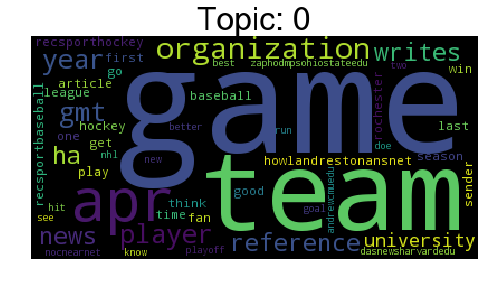

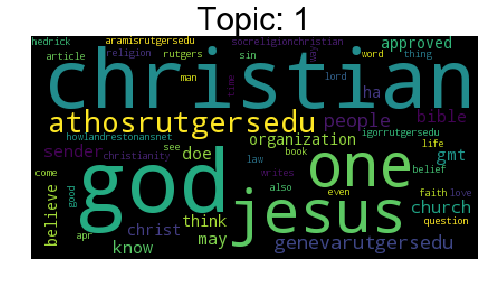

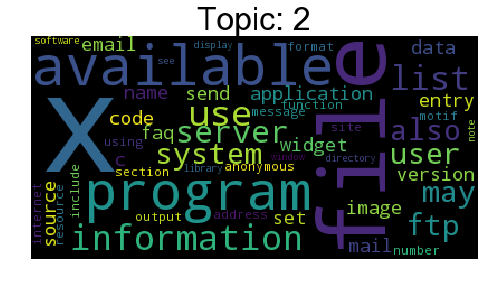

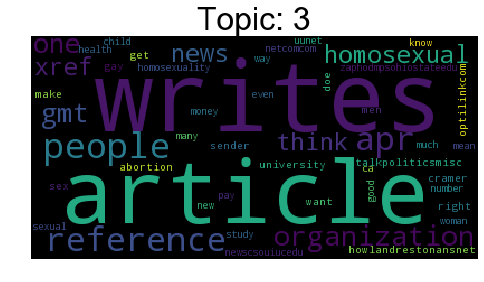

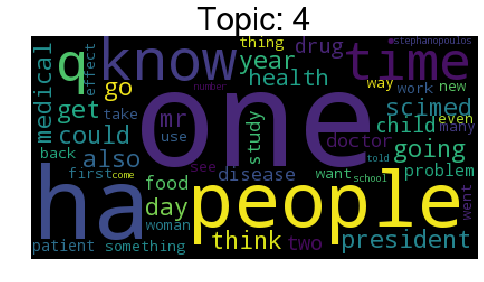

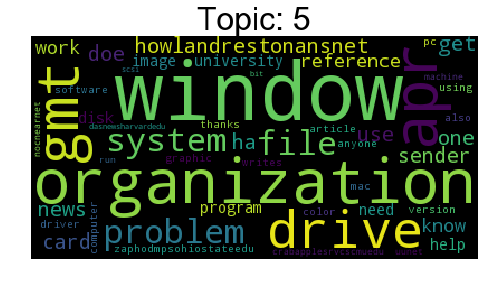

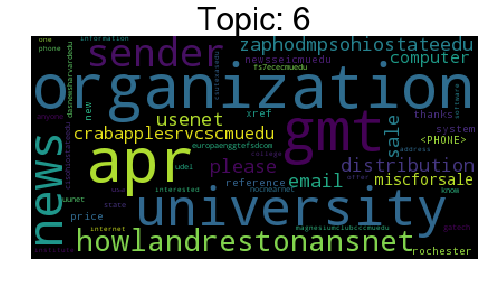

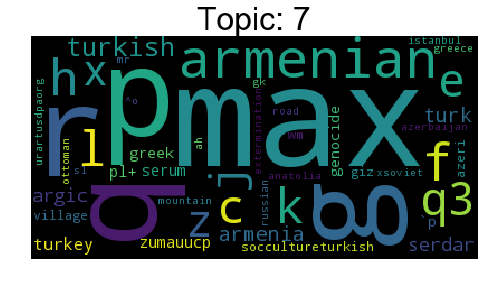

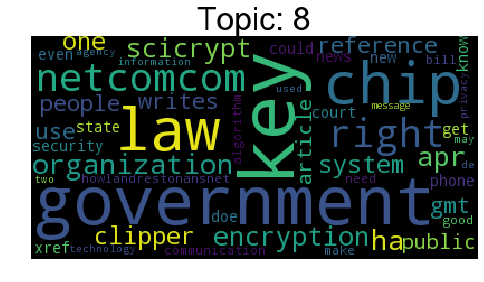

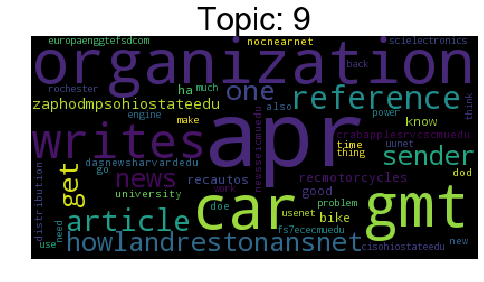

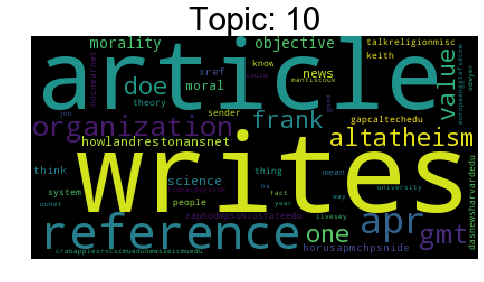

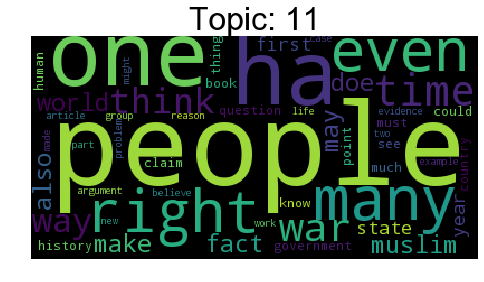

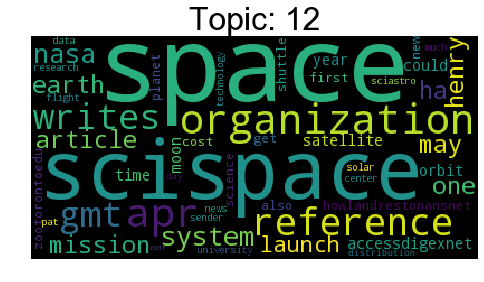

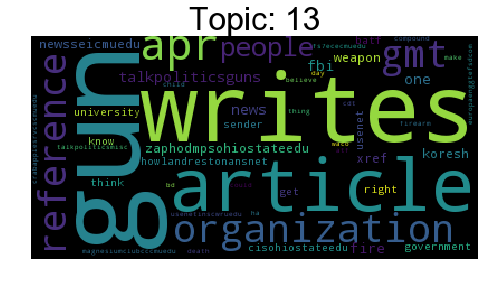

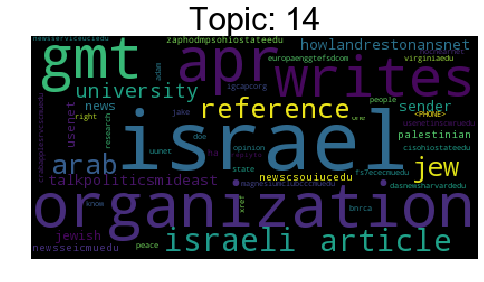

In [77]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    """ https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html """
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def showTopicCloud(toks, topic):
    """
        Show tagcloud for the supplied dataframe containing tokens and their weights
    """ 
    wordcloud = WordCloud().generate_from_frequencies(dict(toks))
    plt.figure(figsize=(8,5))
    #Turn this on if you'd rather have wordclouds in grayscale
    #plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3))
    plt.imshow(wordcloud)   
    plt.axis("off")
    plt.title('Topic: {0}'.format(topic), fontsize=32, color = '#000000')
    plt.show()
    
for topic in list(set(df_topic_dist['topicid'].tolist())):
    toks = df_topic_dist[df_topic_dist.topicid==topic][['word', 'prob']].values.tolist()
    showTopicCloud(toks, topic)

In [78]:
%%read_sql _

--1) Define UDF to find most frequently occurring element in a list
create or replace function demo.most_frequent_item(arr int[])
returns int
as
$$
    from collections import defaultdict
    from operator import itemgetter
    result = defaultdict(int)
    for k in arr:
        result[k]+=1
    return max(result.iteritems(), key=itemgetter(1))[0]
$$language plpythonu;

--2) Invoke the UDF to append a column containing the predominant topic for this recid
drop table if exists demo.twenty_news_groups_w_dominant_topic cascade;
create table demo.twenty_news_groups_w_dominant_topic
as
(
    select
        demo.most_frequent_item(t2.topic_assignment) as dominant_topic,
        t1.*
    from
        demo.twenty_news_groups t1,
        demo.twenty_news_groups_lda_results t2
    where t1.doc_id = t2.docid
) distributed by (doc_id);

Query started at 02:24:51 PM EDT; Query executed in 2.64 m

In [79]:
%%read_sql df
select * from demo.twenty_news_groups_w_dominant_topic limit 40;

Query started at 02:27:29 PM EDT; Query executed in 0.00 m

dominant_topic  doc_id  \
0   11              1        
1   1               3        
2   1               5        
3   11              7        
4   10              9        
5   10              11       
6   10              13       
7   11              0        
8   10              15       
9   1               17       
10  10              19       
11  1               2        
12  3               4        
13  10              6        
14  1               21       
15  10              23       
16  10              8        
17  10              10       
18  10              12       
19  10              14       
20  10              16       
21  11              18       
22  11              25       
23  1               27       
24  10              29       
25  3               31       
26  10              33       
27  11              20       
28  10              22       
29  10              24       
30  3               35       
31  1               37       
32  10              26       
33  6               28       
34  10              30       
35  10              32       
36  10              39       
37  10              41       
38  10              43       
39  4               34       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     